In [1]:
import array
import os
import struct

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
import numpy as np
import seaborn as sns
from scipy import signal

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

In [2]:
def read_block(fl):
    # read header of block
    # read magic number + sampling rate + number of samples
    header_bytes = fl.read(12)
    header = struct.unpack(">III", header_bytes)
    magic_number, sample_rate, num_samples = header
    if hex(magic_number) != "0xdeadbeef":
        raise Exception("Invalid magic number " + str(magic_number))

    bytes_to_read = num_samples * 2
    sample_bytes = fl.read(bytes_to_read)
    if len(sample_bytes) < bytes_to_read:
        raise Exception("Block has fewer samples than expected")

    samples = array.array("h", sample_bytes)
    samples.byteswap()

    return samples

In [3]:
blocks = []

with open("dish_washer_audio_1sec.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)
    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

with open("dish_washer_audio_3sec-1.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

with open("dish_washer_audio_3sec-2.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
        except:
            break

n_blocks = len(blocks)
print(n_blocks)

with open("dish_washer_audio_3sec-3.bin", "rb") as fl:
    fl.seek(0, os.SEEK_END)
    fl_size = fl.tell() / 1024 / 1024 # bytes to megabytes
    print(fl_size)
    fl.seek(0, os.SEEK_SET)

    n = 0
    while True:
        try:
            block = read_block(fl)
            blocks.append(block)
            n += 1
        except:
            break
    print(n)

n_blocks = len(blocks)
print(n_blocks)

35.00914001464844
824.6220779418945
99.1596794128418
8971
348.9776725769043
3041
12012


In [4]:
concat_blocks = []
for b in blocks:
    concat_blocks.extend(b)

Text(0, 0.5, 'Magnitude')

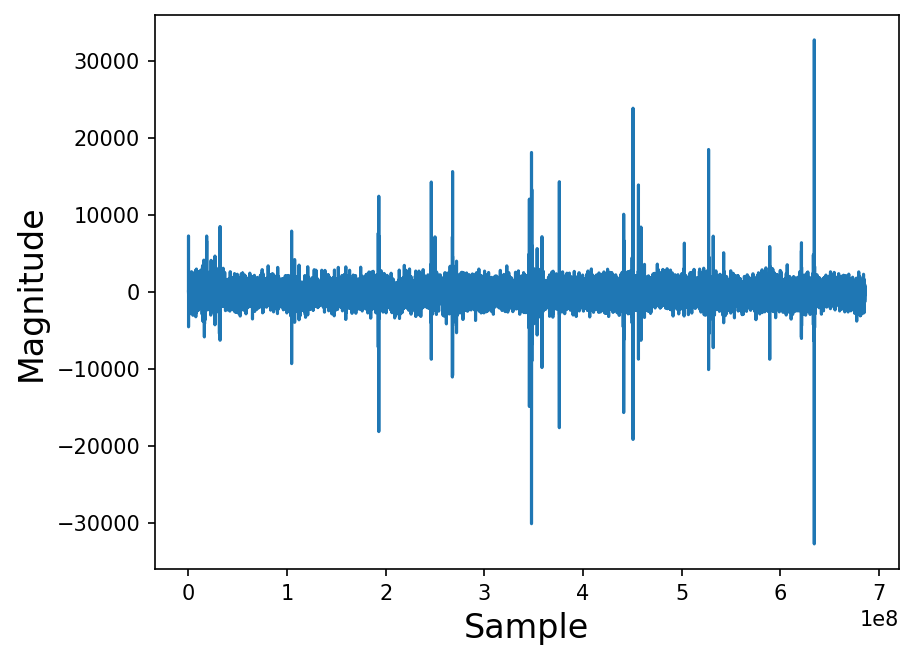

In [5]:
plt.plot(concat_blocks)
plt.xlabel("Sample", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

Text(0, 0.5, 'Magnitude')

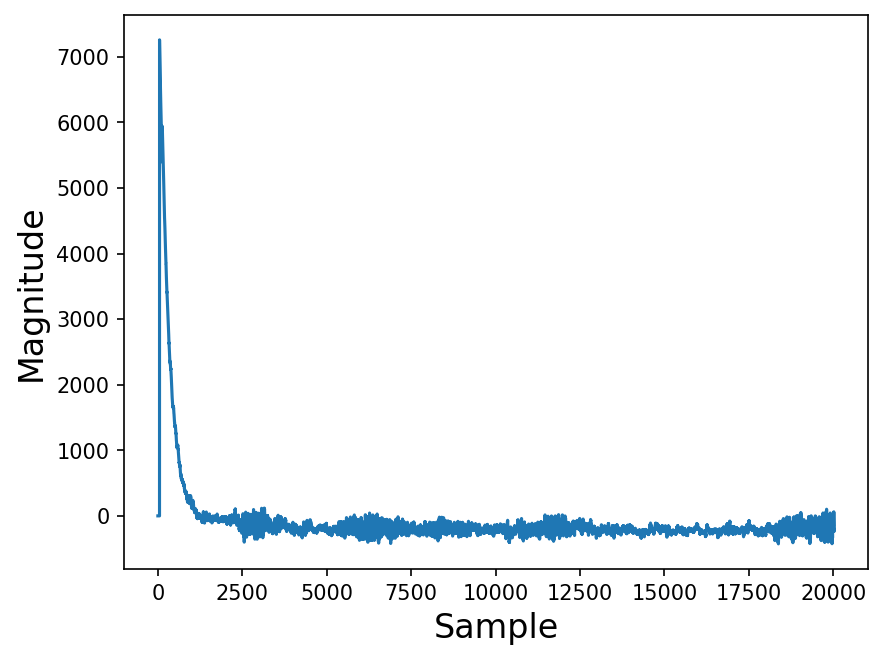

In [6]:
plt.plot(blocks[1])
plt.xlabel("Sample", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

In [7]:
block_end = 2 ** 14
block_tails = [b[-block_end:] for b in blocks]

In [8]:
concat_blocks = []
for b in block_tails:
    concat_blocks.extend(b)

Text(0, 0.5, 'Magnitude')

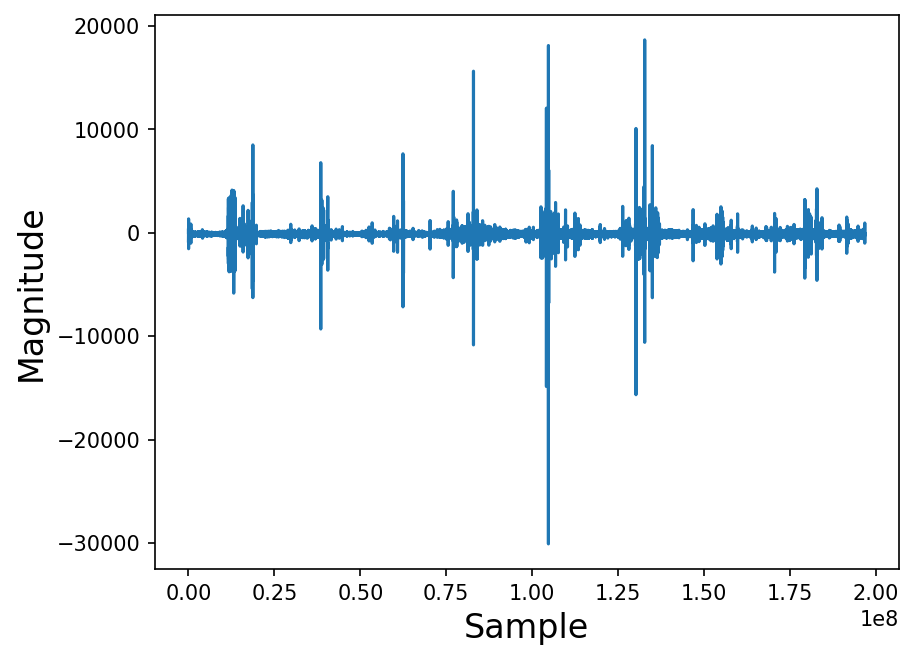

In [9]:
plt.plot(concat_blocks)
plt.xlabel("Sample", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

Text(0, 0.5, 'Magnitude')

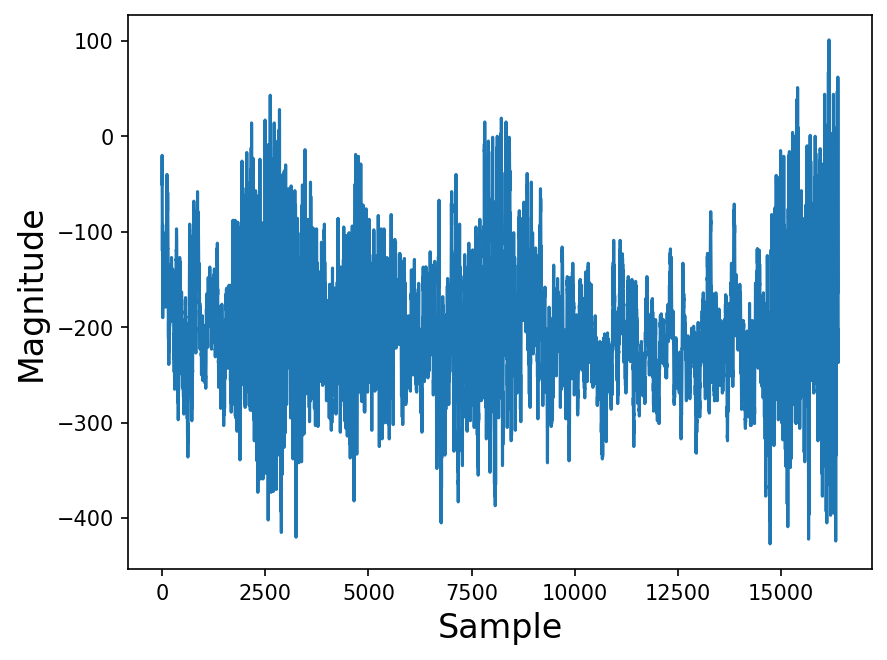

In [10]:
plt.plot(block_tails[1])
plt.xlabel("Sample", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

Text(0, 0.5, 'Std. Dev.')

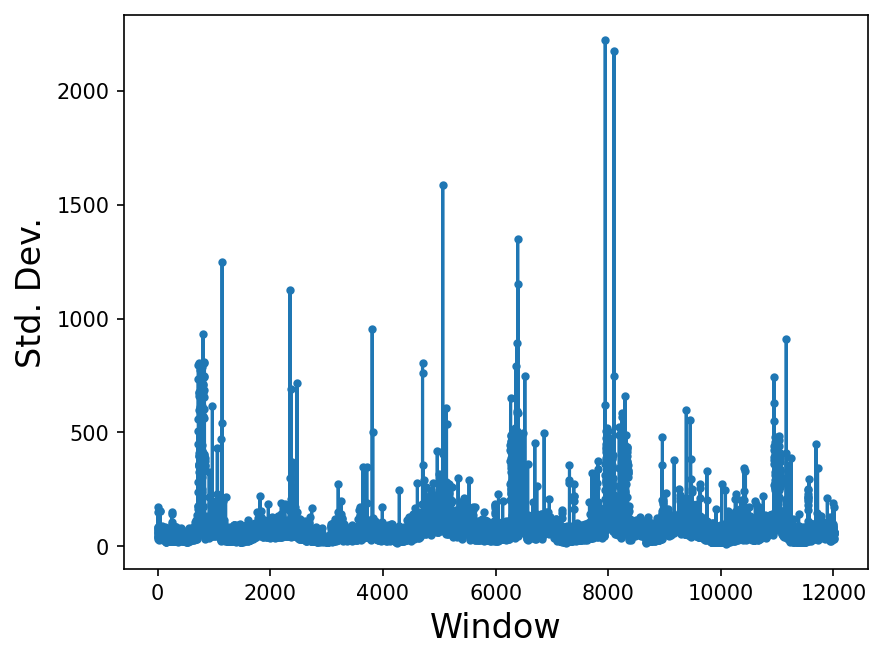

In [11]:
block_std = [np.std(b) for b in block_tails]
plt.plot(block_std, marker=".")
plt.xlabel("Window", fontsize=16)
plt.ylabel("Std. Dev.", fontsize=16)

Text(0, 0.5, 'Std. Dev.')

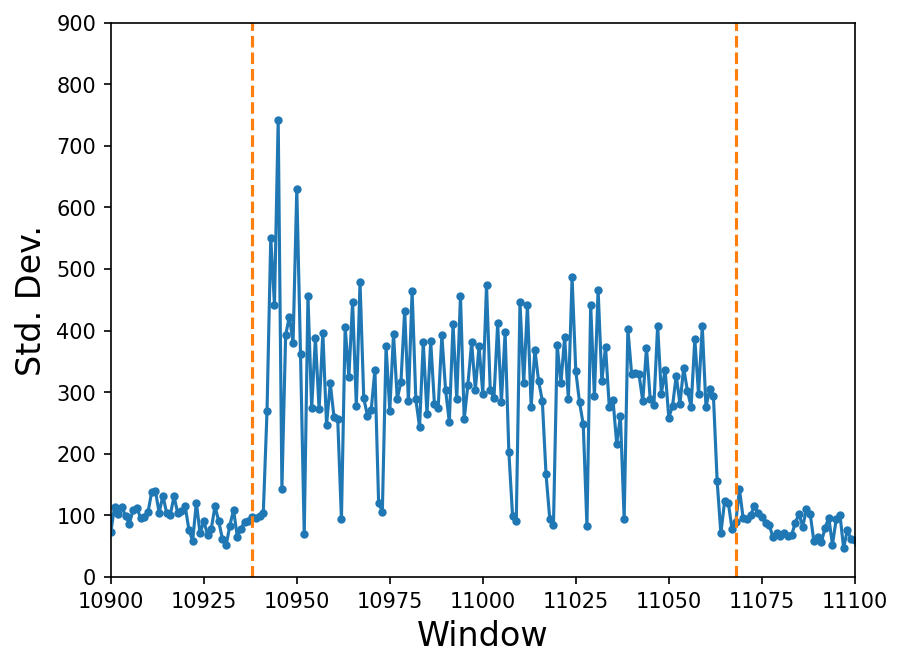

In [12]:
plt.plot(block_std, marker=".")
#plt.xlim([10938, 11068])
plt.xlim([10900, 11100])
plt.plot([10938, 10938], [0, 1000], linestyle="--", color="tab:orange")
plt.plot([11068, 11068], [0, 1000], linestyle="--", color="tab:orange")
plt.ylim([0, 900])
plt.xlabel("Window", fontsize=16)
plt.ylabel("Std. Dev.", fontsize=16)

In [13]:
# 1 - dish washer on, 0 - dish washer off
labels = np.zeros(n_blocks)
labels[700 : 840] = 1.0
labels[6255 : 6405] = 1.0
labels[7930 : 8080] = 1.0
labels[8230 : 8355] = 1.0
labels[10938 : 11068] = 1.0

block_spectra_list = [np.abs(np.fft.rfft(b, norm="forward")) for b in block_tails]
block_spectra = np.vstack(block_spectra_list)
print(n_blocks, block_spectra.shape)

features = block_spectra

print(features.shape)

12012 (12012, 8193)
(12012, 8193)


In [14]:
split_point = 8971
train_X = features[:split_point, :]
test_X = features[split_point:, :]
train_y = labels[:split_point]
test_y = labels[split_point:]

In [15]:
model = linear_model.LogisticRegression(max_iter=250)
model.fit(np.log1p(train_X), train_y)

pred_y = model.predict(np.log1p(test_X))
precision = metrics.precision_score(test_y, pred_y)
recall = metrics.recall_score(test_y, pred_y)
balanced = metrics.balanced_accuracy_score(test_y, pred_y)

print("Precision: {:.1f}".format(100. * precision))
print("Recall: {:.1f}".format(100. * recall))
print("Balanced accuracy: {:.1f}".format(100. * balanced))
print(metrics.confusion_matrix(test_y, pred_y))

Precision: 91.9
Recall: 86.9
Balanced accuracy: 93.3
[[2901   10]
 [  17  113]]


In [16]:
model = linear_model.LogisticRegression()
scaler = preprocessing.StandardScaler()
model.fit(scaler.fit_transform(np.log1p(train_X)), train_y)

pred_y = model.predict(scaler.transform(np.log1p(test_X)))
precision = metrics.precision_score(test_y, pred_y)
recall = metrics.recall_score(test_y, pred_y)
balanced = metrics.balanced_accuracy_score(test_y, pred_y)

print("Precision: {:.1f}".format(100. * precision))
print("Recall: {:.1f}".format(100. * recall))
print("Balanced accuracy: {:.1f}".format(100. * balanced))
print(metrics.confusion_matrix(test_y, pred_y))

Precision: 92.2
Recall: 90.8
Balanced accuracy: 95.2
[[2901   10]
 [  12  118]]


In [17]:
model = svm.LinearSVC()
scaler = preprocessing.StandardScaler()
model.fit(scaler.fit_transform(np.log1p(train_X)), train_y)

pred_y = model.predict(scaler.transform(np.log1p(test_X)))
precision = metrics.precision_score(test_y, pred_y)
recall = metrics.recall_score(test_y, pred_y)
balanced = metrics.balanced_accuracy_score(test_y, pred_y)

print("Precision: {:.1f}".format(100. * precision))
print("Recall: {:.1f}".format(100. * recall))
print("Balanced accuracy: {:.1f}".format(100. * balanced))
print(metrics.confusion_matrix(test_y, pred_y))

Precision: 77.9
Recall: 92.3
Balanced accuracy: 95.6
[[2877   34]
 [  10  120]]


In [18]:
model = linear_model.LogisticRegression(max_iter=250)
scaler = preprocessing.StandardScaler()
# drop 0th freq
scaled_train_X = scaler.fit_transform(np.log1p(train_X))
model.fit(scaled_train_X, train_y)

scaled_test_X = scaler.transform(np.log1p(test_X))
pred_y = model.predict(scaled_test_X)
precision = metrics.precision_score(test_y, pred_y)
recall = metrics.recall_score(test_y, pred_y)
balanced = metrics.balanced_accuracy_score(test_y, pred_y)

print("Precision: {:.1f}".format(100. * precision))
print("Recall: {:.1f}".format(100. * recall))
print("Balanced accuracy: {:.1f}".format(100. * balanced))
print(metrics.confusion_matrix(test_y, pred_y))

Precision: 92.2
Recall: 90.8
Balanced accuracy: 95.2
[[2901   10]
 [  12  118]]


In [19]:
def numpy_float_to_cstr(f):
    return str(f.item()) + "f"

def numpy_array_cstr(array):
    str_list = map(numpy_float_to_cstr, array)
    return "{" + ", ".join(str_list) + "}";

def generate_c_code(scaler, model):
    coef = model.coef_[0]
    intercept = model.intercept_[0].item()

    coefs_str = numpy_array_cstr(coef)
    means_str = numpy_array_cstr(scaler.mean_)
    std_devs_str = numpy_array_cstr(scaler.scale_)

    variable_template = """// number of features
static const uint32_t N_MODEL_FEATURES = {n_features};
// logistic regression intercept
static const float MODEL_INTERCEPT = {intercept:f}f;
// logistic regression feature weights -- one per feature
static const float MODEL_COEFS[] = {coefs_str};
// standard scaling means -- one per feature
static const float SCALER_MEANS[] = {means_str};
// standard scaling standard deviations -- one per feature
static const float SCALER_STD_DEVS[] = {std_devs_str};
"""
    function_code = """bool applyModel(float* features) {
  float s = MODEL_INTERCEPT;
  for(uint32_t i = 0; i < N_MODEL_FEATURES; i++) {
    float log_feature = log1p(features[i]);
    float scaled_feature = (log_feature - SCALER_MEANS[i]) / SCALER_STD_DEVS[i];
    s += MODEL_COEFS[i] * scaled_feature;
  }

  return s > 0;
}
"""
    variable_code = variable_template.format(n_features=len(coef), coefs_str = coefs_str, intercept = intercept, std_devs_str = std_devs_str, means_str = means_str)

    return variable_code + "\n\n" + function_code

In [21]:
code = generate_c_code(scaler, model)

for ln in code.split("\n"):
    print(ln)

// number of features
static const uint32_t N_MODEL_FEATURES = 8193;
// logistic regression intercept
static const float MODEL_INTERCEPT = -6.532477f;
// logistic regression feature weights -- one per feature
static const float MODEL_COEFS[] = {-0.022756957726935492f, -0.028174850271323333f, -0.07388052317533829f, -0.024142133174726098f, -0.05639168763597101f, -0.03707428508934893f, -0.05876200755737901f, -0.03719680304979937f, 0.049273184606580166f, 0.004828399295710691f, 0.014398216702942536f, -0.008820252461866289f, 0.04473571199958223f, 0.0015287876635700385f, -0.040814771002052955f, 0.037086985294548534f, -0.018062712042555284f, 0.021668603473946044f, -0.023675057868941675f, 0.024555134083742994f, 0.017240975335585842f, -0.06678795455748716f, -0.04206796114663129f, 0.001099351789196907f, -0.00409317488266036f, 0.046973858789466715f, 0.012196990456714473f, -0.016261800077660784f, -0.03305615623364822f, 0.02013887650876396f, -0.004054678256813779f, 0.0032252465174675182f, 0.00059799